# Quantum Portfolio Optimization

This notebook demonstrates **modern portfolio optimization** using both classical and quantum computing approaches.

1. **📈 Classical Modern Portfolio Theory (MPT)**
   - Mean-variance optimization with real financial data
   - Efficient frontier analysis and Sharpe ratio maximization

2. **🔬 Quantum Portfolio Optimization (QAOA)**
   - Quantum Approximate Optimization Algorithm implementation
   - Integer-constrained portfolio optimization using Qiskit

## 📊 Data Preparation and Analysis

We begin by importing essential libraries and fetching real financial data to create a realistic portfolio optimization scenario.

In [1]:
# Libraries for Classical finance optimization
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from scipy.optimize import minimize

In [2]:
# Define our portfolio assets (example: Tech stocks)
tickers = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA']
start_date = '2025-01-01'
end_date = date.today().isoformat()

# Fetch historical data
def get_stock_data(tickers: list[str], start_date: str, end_date: str) -> pd.DataFrame:
    data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)["Close"]
        data[ticker] = stock
    return data

# Get daily prices and calculate returns
print(f'Fetching data from {start_date} to {end_date}...')
prices = get_stock_data(tickers, start_date, end_date)
returns = prices.pct_change().dropna()

# Display basic statistics
print('\nDaily Returns Statistics:')
print(returns.describe())

Fetching data from 2025-01-01 to 2025-08-28...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


Daily Returns Statistics:
             AAPL        AMZN       GOOGL        META        MSFT        NVDA
count  162.000000  162.000000  162.000000  162.000000  162.000000  162.000000
mean    -0.000055    0.000503    0.000789    0.001711    0.001357    0.002302
std      0.023527    0.022865    0.020677    0.026277    0.017076    0.035176
min     -0.092456   -0.089791   -0.072924   -0.089583   -0.061809   -0.169682
25%     -0.009103   -0.010627   -0.009439   -0.012110   -0.005928   -0.011162
50%      0.000480    0.000202    0.001513    0.001836    0.000562    0.003943
75%      0.008723    0.013122    0.013761    0.012417    0.007400    0.019170
max      0.153289    0.119770    0.096821    0.147556    0.101337    0.187227


### 📈 Financial Data Collection

Let's fetch real stock data for our portfolio optimization analysis:

Expected Annual Returns:
AAPL: -0.014 (-1.4%)
AMZN: 0.127 (12.7%)
GOOGL: 0.199 (19.9%)
META: 0.431 (43.1%)
MSFT: 0.342 (34.2%)
NVDA: 0.580 (58.0%)

Risk (Standard Deviation):
AAPL: 0.373 (37.3%)
AMZN: 0.363 (36.3%)
GOOGL: 0.328 (32.8%)
META: 0.417 (41.7%)
MSFT: 0.271 (27.1%)
NVDA: 0.558 (55.8%)


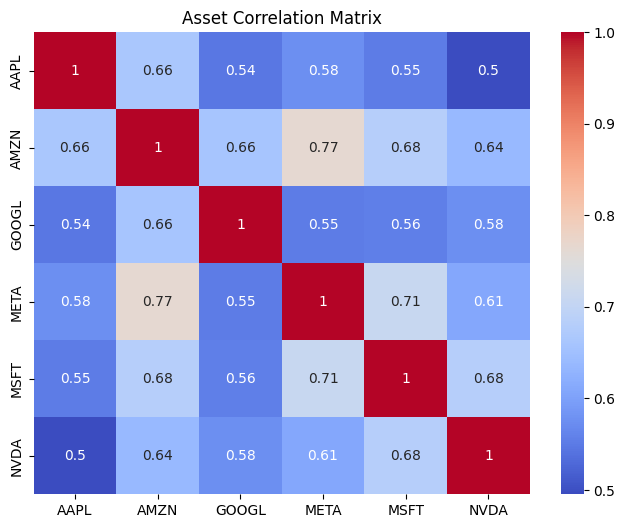

In [3]:
# Calculate expected returns and risk (covariance matrix)
mu = returns.mean() * 252  # Annualized returns
sigma = returns.cov() * 252  # Annualized covariance

print("Expected Annual Returns:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {mu[ticker]:.3f} ({mu[ticker]*100:.1f}%)")

print("\nRisk (Standard Deviation):")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {np.sqrt(np.diag(sigma))[i]:.3f} ({np.sqrt(np.diag(sigma))[i]*100:.1f}%)")

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
plt.title('Asset Correlation Matrix')
plt.show()

## 🧮 Classical Portfolio Analysis

Statistical analysis of portfolio returns and risks:

$$
\begin{align*}
\text{Portfolio Return: } R_p &= \sum_{i=1}^{N} w_i R_i \\[5ex]
\text{Portfolio Risk: } \sigma_p &= \sqrt{\sum_{i=1}^{N} \sum_{j=1}^{N} w_i w_j \sigma_{ij}} \\[7ex]
\text{Sharpe Ratio: } S &= \frac{R_p - R_f}{\sigma_p} \\
\end{align*}
$$

Based on the Modern Portfolio Theory (MPT), we analyze the efficient frontier and optimal asset allocation using classical optimization methods.

In [4]:
# Portfolio statistics calculation
def portfolio_stats(weights: list[float], mu: pd.Series, sigma: pd.DataFrame, rf: float) -> tuple[float, float, float]:
    """Calculate portfolio return and risk"""
    portfolio_return = np.dot(weights, mu)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_risk
    return portfolio_return, portfolio_risk, sharpe_ratio


# Generate efficient frontier points
def efficient_frontier(mu: pd.Series, sigma: pd.DataFrame, rf: float, num_portfolios: int) -> np.ndarray:
    """Generate efficient frontier"""
    n_assets = len(mu)
    frontier = np.zeros((3, num_portfolios))  # rows: return, risk, sharpe ratio
    
    # Create target returns from min to max expected returns
    target_returns = np.linspace(mu.min(), mu.max(), num_portfolios)
    
    for i, target in enumerate(target_returns):
        # Minimize risk for target return
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
            {'type': 'eq', 'fun': lambda x: np.dot(x, mu) - target}  # target return
        ]
        bounds = tuple((0, 1) for _ in range(n_assets))  # Weights between 0 and 1 (no short selling)

        # SLSQP minimizes a scalar function of multiple variables,
        # particularly when the problem includes:
        #  - bounds, 
        #  - equality constraints, and/or 
        #  - inequality constraints.
        result = minimize(
            lambda x: np.dot(x.T, np.dot(sigma, x)),  # minimize variance
            x0=np.array([1/n_assets] * n_assets),     # initial guess == equal weights
            method='SLSQP',                           # Sequential Least Squares Programming
            bounds=bounds,
            constraints=constraints
        )
        
        if result.success:
            portfolio_return, portfolio_risk, sharpe_ratio = portfolio_stats(result.x, mu, sigma, rf)
            frontier[0, i] = portfolio_return
            frontier[1, i] = portfolio_risk
            frontier[2, i] = sharpe_ratio
        else:
            print(f"Optimization failed for target return {target:.4f}: {result.message}")
            frontier[0, i] = np.nan
            frontier[1, i] = np.nan
            frontier[2, i] = np.nan

    return frontier


def optimal_portfolio(mu: pd.Series, sigma: pd.DataFrame, rf: float) -> tuple[np.ndarray, float, float, float]:
    """Find the portfolio with the maximum Sharpe ratio"""
    n_assets = len(mu)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # weights sum to 1
    bounds = tuple((0, 1) for _ in range(n_assets))  # Weights between 0 and 1 (no short selling)

    # Optimize for maximum Sharpe ratio (minimum negative Sharpe ratio)
    result = minimize(
        lambda x: -portfolio_stats(x, mu, sigma, rf)[2],  # maximize Sharpe ratio
        x0=np.array([1/n_assets] * n_assets),             # initial guess == equal weights
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if not result.success:
        raise ValueError(f"Sharpe Ratio Optimization failed: {result.message}")

    # Extract optimal weights and stats
    optimal_weights = result.x
    opt_return, opt_risk, opt_sharpe = portfolio_stats(optimal_weights, mu, sigma, rf)
    return optimal_weights, opt_return, opt_risk, opt_sharpe

Find the optimal portfolio weights that maximize the Sharpe ratio.

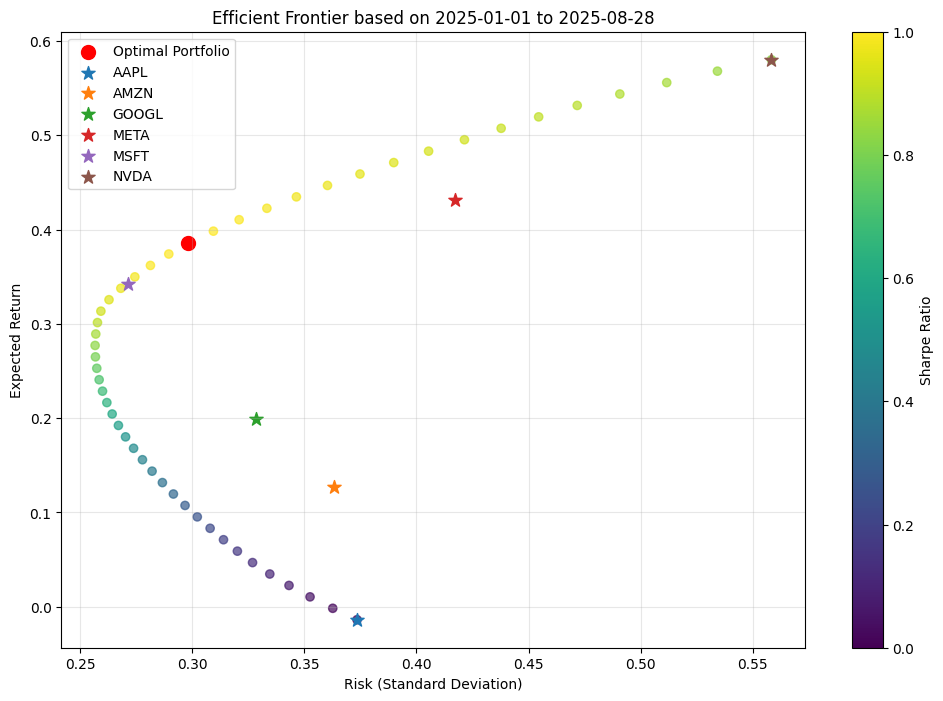

Optimal Portfolio:
------------------
Sharpe Ratio    : 1.225
Expected Return : 0.385 (38.5%)
Risk            : 0.298 (29.8%)
Risk-Free Rate  : 0.020 (2.0%)


,Weight
Ticker,
MSFT,0.74 (74.1%)
NVDA,0.14 (13.6%)
META,0.12 (12.3%)
AMZN,0.00 (0.0%)
AAPL,0.00 (0.0%)
GOOGL,0.00 (0.0%)


In [5]:
# risk-free rate
rf = 0.02

# Calculate and plot efficient frontier based on the annualized returns and risk
portfolio_returns, portfolio_risks, sharpe_ratios = efficient_frontier(mu, sigma, rf, num_portfolios=50)
optimal_weights, opt_return, opt_risk, opt_sharpe = optimal_portfolio(mu, sigma, rf)

# Plot efficient frontier, individual assets, and optimal portfolio
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_risks, portfolio_returns, c=sharpe_ratios, cmap='viridis', alpha=0.7)
plt.scatter(opt_risk, opt_return, c='red', marker='o', s=100, label='Optimal Portfolio')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title(f'Efficient Frontier based on {start_date} to {end_date}')

# Plot individual assets
for i, ticker in enumerate(tickers):
    asset_return = mu[ticker]
    asset_risk = np.sqrt(sigma.iloc[i, i])
    plt.scatter(asset_risk, asset_return, marker='*', s=100, label=ticker)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display optimal portfolio
print("Optimal Portfolio:")
print("------------------")
print(f"Sharpe Ratio    : {opt_sharpe:.3f}")
print(f"Expected Return : {opt_return:.3f} ({opt_return*100:.1f}%)")
print(f"Risk            : {opt_risk:.3f} ({opt_risk*100:.1f}%)")
print(f"Risk-Free Rate  : {rf:.3f} ({rf*100:.1f}%)")

# Display weights
optimal_df = pd.DataFrame({
    'Ticker': tickers,
    'Weight': optimal_weights,
})
optimal_df.set_index('Ticker', inplace=True)
optimal_df = optimal_df.sort_values(by='Weight', ascending=False)
optimal_df = optimal_df.style.format({'Weight': lambda x: f'{x:.2f} ({x*100:.1f}%)'})
display(optimal_df)

## Quantum Portfolio Optimization (QAOA)

We solve the same portfolio optimization problem using quantum combinatorial optimization. 

**Key Difference**: QAOA uses binary variables for asset selection instead of continuous weights.

| Aspect | Classical (MPT) | Quantum (QAOA) |
|--------|-----------------|----------------|
| **Variables** | Continuous (0-100%) | Binary (0 or 1) |
| **Algorithm** | SLSQP | Quantum circuits |
| **Constraints** | Sum = 1 | None (pure selection) |
| **Allocation** | Fractional weights | Equal weights for selected assets |

In our QAOA implementation:
- Classical: 30.5% in AAPL, 15.2% in MSFT, 54.3% in NVDA
- Quantum: Select AAPL and NVDA (bitstring "101000"), then equal weights: 50% each

We formulate the portfolio optimization problem as a **Quadratic Unconstrained Binary Optimization (QUBO)**, which maps naturally to an **Ising Hamiltonian**:

$$
H_C = \sum_{i<j} J_{ij}\, Z_i Z_j + \sum_i h_i Z_i,
$$
where:
- $J_{ij}$ encodes the **interaction** (correlation/penalty) between assets $i$ and $j$  
- $h_i$ encodes the **bias** (cost or contribution) of asset $i$

In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

### Initialization

Start from the equal superposition state:
$$
|\psi_0\rangle = |+\rangle^{\otimes n} 
= \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle,
$$
representing all possible portfolio allocations uniformly.

### QAOA Circuit (Layers)

For depth $p$, each layer $\ell=1,\dots,p$ alternates between:

1. **Cost Hamiltonian evolution**  
   $$
   U_C(\gamma_\ell) = e^{-i \gamma_\ell H_C}
   $$

2. **Mixer Hamiltonian evolution** (with $H_M = \sum_i X_i$)  
   $$
   U_M(\beta_\ell) = e^{-i \beta_\ell H_M}
   $$

The full $\ell$-th layer is:
$$
U(\beta_\ell,\gamma_\ell) = U_M(\beta_\ell)\, U_C(\gamma_\ell).
$$

### Final State

After $p$ layers:
$$
|\psi_p(\boldsymbol\beta,\boldsymbol\gamma)\rangle
= \Bigg[\prod_{\ell=1}^{p} U_M(\beta_\ell) U_C(\gamma_\ell)\Bigg] \, |\psi_0\rangle.
$$

### Measurement

Measuring in the computational basis yields bitstrings
$$
x \in \{0,1\}^n,
$$
where each bit indicates asset inclusion/exclusion in the portfolio.

A classical optimizer updates $(\boldsymbol\beta,\boldsymbol\gamma)$ to minimize
$$
\langle \psi_p | H_C | \psi_p \rangle,
$$
steering the quantum state toward optimal portfolio allocations.

In [7]:

# Create QAOA circuit for portfolio optimization
def create_qaoa_circuit(n_qubits: int, params: np.ndarray) -> QuantumCircuit:
    beta, gamma = params[:len(params)//2], params[len(params)//2:]
    p = len(beta)  # Number of QAOA layers
    
    qc = QuantumCircuit(n_qubits)
    
    # Initial state: equal superposition |000...0> => |+++...+>
    qc.h(range(n_qubits))
    
    # QAOA layers
    for layer in range(p):
        # Problem Hamiltonian (cost function)
        # Apply RZZ gates for correlations between assets
        for i in range(n_qubits):
            for j in range(i+1, n_qubits):
                qc.rzz(2 * gamma[layer], i, j)
        
        # Apply Z gates for individual asset costs
        for i in range(n_qubits):
            qc.rz(2 * gamma[layer], i)
        
        # Mixer Hamiltonian (X rotations)
        for i in range(n_qubits):
            qc.rx(2 * beta[layer], i)
    
    # Measurement
    qc.measure_all()
    return qc

The sharpe ratio is calculated as:
$$
S = \frac{R_p - R_f}{\sigma_p}
$$
where $R_p$ is the portfolio return, $\sigma_p$ is the portfolio risk (standard deviation), and $R_f$ is the risk-free rate.

In [8]:
# Sharpe ratio calculation
def calculate_sharpe_ratio(bitstring: str, mu: pd.Series, sigma: pd.DataFrame, risk_free: float) -> float:
    selection = np.array([int(bit) for bit in bitstring])
    if np.sum(selection) == 0:
        return -1000  # Avoid division by zero
    
    expected_return = np.dot(mu.values, selection)
    variance = selection @ sigma.values @ selection
    std_dev = np.sqrt(variance)
    
    sharpe = (expected_return - risk_free) / std_dev if std_dev > 0 else -np.inf
    return sharpe

We want to maximize the Sharpe ratio, which we convert to a minimization problem by negating it.

In [9]:
# Run QAOA optimization for portfolio selection
def run_qaoa_optimization(mu: pd.Series, sigma: pd.DataFrame, risk_free: float, n_layers: int, n_shots:int, max_iter: int) -> dict:
    n_assets = len(mu)

    simulator = AerSimulator()
    
    def objective_function(params):
        # Create and run circuit directly
        qc = create_qaoa_circuit(n_assets, params)
        
        # Run on AerSimulator - simple and reliable
        transpiled_qc = transpile(qc, simulator)
        job = simulator.run(transpiled_qc, shots=n_shots)
        counts = job.result().get_counts()
        
        # Calculate expectation value
        total_cost = 0
        total_shots = sum(counts.values())
        
        # Cost function: negative Sharpe ratio
        for bitstring, count in counts.items():
            cost = -calculate_sharpe_ratio(bitstring, mu, sigma, risk_free)
            total_cost += cost * count / total_shots
        
        return total_cost
    
    # Optimize QAOA parameters
    initial_params = np.random.uniform(0, np.pi/4, 2*n_layers)
    
    result = minimize(
        objective_function,
        initial_params,
        method="COBYLA",
        options=dict(
            disp = True,
            maxiter = max_iter,
        ),
    )

    if not result.success:
        raise ValueError(f"QAOA Optimization failed: {result.message}")

    # Get final results with optimized parameters
    final_qc = create_qaoa_circuit(n_assets, result.x)
    transpiled_qc = transpile(final_qc, simulator)
    job = simulator.run(transpiled_qc, shots=n_shots)
    all_counts = job.result().get_counts()
    
    # Find best solution
    bits_counts_sr = [(bits, count, calculate_sharpe_ratio(bits, mu, sigma, risk_free)) for bits, count in all_counts.items()]
    best_bitstring, best_count, sharpe_ratio = max(bits_counts_sr, key=lambda x: x[2])
    
    return {
        'all_counts': all_counts,
        'solution': best_bitstring,
        'count': best_count,
        'sharpe_ratio': sharpe_ratio,
    }


# Run QAOA portfolio optimization
risk_free = 0.02
n_layers = 10
n_shots = 1024
max_iter = 1000

# Run quantum optimization
quantum_result = run_qaoa_optimization(mu, sigma, risk_free, n_layers, n_shots, max_iter)

# Show measurement distribution
print("\nTop measurement outcomes:")
sorted_counts = sorted(quantum_result['all_counts'].items(), key=lambda x: x[1], reverse=True)
for bitstring, count in sorted_counts[:5]:
    prob = count / sum(quantum_result['all_counts'].values())
    sharpe_ratio = calculate_sharpe_ratio(bitstring, mu, sigma, risk_free)
    print(f"   {bitstring}: {prob:.1%} (sharpe ratio: {sharpe_ratio:.3f})")


Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 140   Least value of F = -0.7656210214934264
The corresponding X is:
[0.18961144 0.17397902 0.72939147 0.78926165 0.74323467 0.59701195
 0.69364115 0.45881163 1.56377261 0.30012109 0.38810104 0.79779183
 0.62183898 1.71466584 0.64087406 0.56966992 0.30040989 0.28978309
 0.50718618 0.01839622]


Top measurement outcomes:
   111111: 11.6% (sharpe ratio: 0.862)
   001000: 6.2% (sharpe ratio: 0.545)
   000010: 6.2% (sharpe ratio: 1.188)
   010000: 5.7% (sharpe ratio: 0.294)
   000001: 5.4% (sharpe ratio: 1.003)


## Comparison of Classical and Quantum Results

Finally, we compare the optimal portfolios obtained from both classical and quantum methods.

In [10]:
if quantum_result:
    # Display quantum portfolio results in same format as classical for comparison
    # Calculate quantum portfolio metrics
    best_solution = quantum_result['solution']
    selection = np.array([1 if bit == '1' else 0 for bit in best_solution])
    quantum_weights = selection / np.sum(selection)  # Equal weights for selected assets

    # Calculate portfolio statistics
    quantum_return, quantum_risk, quantum_sharpe = portfolio_stats(quantum_weights, mu, sigma, rf)

    print("\nQuantum Portfolio (QAOA):")
    print("-------------------------")
    print(f"Sharpe Ratio    : {quantum_sharpe:.3f}")
    print(f"Expected Return : {quantum_return:.3f} ({quantum_return*100:.1f}%)")
    print(f"Risk            : {quantum_risk:.3f} ({quantum_risk*100:.1f}%)")
    print(f"Risk-Free Rate  : {rf:.3f} ({rf*100:.1f}%)")

    # Display weights in same format as classical
    quantum_df = pd.DataFrame({
        'Ticker': tickers,
        'Weight': quantum_weights,
    })
    quantum_df.set_index('Ticker', inplace=True)
    quantum_df = quantum_df.sort_values(by='Weight', ascending=False)
    quantum_df = quantum_df.style.format({'Weight': lambda x: f'{x:.2f} ({x*100:.1f}%)'})
    display(quantum_df)

    # Comparison summary
    print("\nComparison:")
    print(f"Classical Sharpe Ratio: {opt_sharpe:.3f}")
    print(f"Quantum Sharpe Ratio:   {quantum_sharpe:.3f}")
    print(f"Difference:             {quantum_sharpe - opt_sharpe:.3f}")
else:
    print("Quantum optimization failed.")


Quantum Portfolio (QAOA):
-------------------------
Sharpe Ratio    : 1.176
Expected Return : 0.451 (45.1%)
Risk            : 0.367 (36.7%)
Risk-Free Rate  : 0.020 (2.0%)


,Weight
Ticker,
META,0.33 (33.3%)
MSFT,0.33 (33.3%)
NVDA,0.33 (33.3%)
AAPL,0.00 (0.0%)
AMZN,0.00 (0.0%)
GOOGL,0.00 (0.0%)



Comparison:
Classical Sharpe Ratio: 1.225
Quantum Sharpe Ratio:   1.176
Difference:             -0.049


## The Bottom Line

In this notebook, we explored both classical and quantum approaches to portfolio optimization.

The classical method provided a continuous allocation of assets, while the quantum approach offered a discrete allocation using QAOA, which does not perform as well as the classical method. Part of the challenge with QAOA is its reliance on discrete variables, which can limit the granularity of asset allocation compared to the continuous weights used in classical optimization. 

Additionally, the performance of QAOA is highly dependent on the choice of parameters and the depth of the quantum circuit, which can be difficult to optimize effectively. 